In [ ]:
# default_exp protocol

# Protocol

> Representation of quantum error correction protocol.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import networkx as nx
from qsam.circuit import make_hash, Circuit
from functools import lru_cache
import pickle
import simpleeval

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

We model a protocol as a directed graph without loops (acyclic `DiGraph`) in which each `node` represents one `circuit` and every `edge` represents a transition rule between circuits, which we call `check`. We give each `node` a **unique** label and a `circuit`. A protocol must always *START* at **one** point and *EXIT* at **one or several** points. The next circuit in a protocol must always be uniquely identifiable. Thus, for each circuit there can only be one check which evaluates to *True* at any time. If this is not a case an error is thrown. If no check evaluates to *True*, the protocol is understood to terminate implicitly, i.e. terminates with status *no logical error occurred*. If an *EXIT* node is reached on the other hand, the protocol terminates explicitly, i.e. with status *logical error occurred*. These events are later explicitly tracked in the samplers.

In [ ]:
#export
class Protocol(nx.DiGraph):
    """Representation of a Quantum Error Correction protocol"""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._circuits = {} # hash table
        
    def add_node(self, name, circuit):
        circuit_hash = make_hash(circuit)
        self._circuits[circuit_hash] = circuit
        super().add_node(name, circuit_hash=circuit_hash)
    
    def update_node(self, node, circuit):
        circuit_hash = make_hash(circuit)
        self._circuits[circuit_hash] = circuit
        self.nodes[node]['circuit_hash'] = circuit_hash
        
    def add_nodes_from(self, names, circuits):
        if not isinstance(circuits, (list,tuple,set)):
            circuits = [circuits] * len(names)
        for name, circuit in zip(names, circuits):
            self.add_node(name, circuit)
    
    def circuit_from_node(self, node):
        circuit_hash = self.circuit_hash(node)
        circuit = self._circuits[circuit_hash]
        return circuit_hash, circuit
    
    def circuit_hash(self, node):
        return self.nodes(data='circuit_hash')[node]
    
    @lru_cache(maxsize=128)
    def checks(self, node):
        adj_nodes = self.out_edges(node)
        return {pair[1]: self.edges[pair]['check'] for pair in adj_nodes}

Helper functions

In [ ]:
#export
def draw_protocol(protocol, save_path=None, figsize=(6,4), layout=nx.kamada_kawai_layout, edge_legend=False, self_loop_offset=(0.03,0.06), color=True):
    """Draw graph representation of protocol"""
    
    plt.figure(figsize=figsize)
    
    pos = layout(protocol)

    nudge = lambda pos, x_shift, y_shift: {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    n_pos = nudge(pos, *self_loop_offset) # offset labels for self-loops

    col_val_map = {'START': '#99ccff', 'EXIT': '#ff9999'}
    if color: col_vals = [col_val_map.get(node, '#ffb266') for node in protocol.nodes]
    else: col_vals = 'white'
    
    node_sizes = max([len(node_str)**2 * 100 for node_str in pos.keys()])
    nx.draw(protocol, pos=pos, with_labels=True, node_color=col_vals, node_size=node_sizes, edgecolors='black')
    
    edge_labels = nx.get_edge_attributes(protocol, 'check')
    if edge_legend:
        n_edge_labels = dict()
        legend_labels = []

        cnt = 0
        for k,v in edge_labels.items():
            if v == 'True':
                n_edge_labels[k] = v
            else:
                i = n_edge_labels.get(k, None)
                if not i:
                    i = cnt
                    cnt += 1

                n_edge_labels[k] = f'${i}$'            
                legend_elem = mlines.Line2D([], [], color='black', marker=f'${i}$', linestyle='None', markersize=8, label=v)
                legend_labels.append(legend_elem)
                
        lgd = plt.legend(handles=legend_labels, bbox_to_anchor=(1.04, 1), loc="upper left")
        edge_labels = n_edge_labels
        
    edge_labels_self_loops = {(to,fr): lbl for (to,fr), lbl in edge_labels.items() if to == fr}
    edge_labels_no_loops = {(to,fr): lbl for (to,fr), lbl in edge_labels.items() if to != fr}
    
    rotate = False if edge_legend else True

    for ps, lbls in zip([pos,n_pos], [edge_labels_no_loops, edge_labels_self_loops]):
        nx.draw_networkx_edge_labels(protocol, ps, lbls, font_size=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'), rotate=rotate)

    if save_path and edge_legend: plt.savefig(save_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    elif save_path: plt.savefig(save_path, bbox_inches='tight')


In [ ]:
#export
default_fns = simpleeval.DEFAULT_FUNCTIONS.copy()
default_fns.update(
    len=len,
    bin=bin,
    parity=lambda x, y: bin(x).count('1') % 2 == y if x else False
)

In [ ]:
#export
def iterate(protocol, eval_fns={}):
    """Iterator over protocol"""
        
    if eval_fns: eval_fns.update(default_fns)
    else: eval_fns = default_fns
    
    hist = {}
    node = "START"
    name_handler = lambda ast_node: hist.get(ast_node.id, None)
    
    while True:
        checks = {n: simpleeval.simple_eval(check, names=name_handler, functions=eval_fns) 
                  for n,check in protocol.checks(node).items()}
        next_nodes = [(nn,check) for nn,check in checks.items() if check]
        
        if len(next_nodes) == 0: 
            yield None
        elif len(next_nodes) == 1: 
            node, check_ret = next_nodes[0]
            
            if isinstance(check_ret, Circuit): # check return can be Circuit in case of COR nodes.
                protocol.update_node(node, check_ret)

            msmt = yield node
            hist[node] = hist.get(node,[]) + [msmt]
        else: 
            raise Exception(f"Too many checks True for node {node}.") 

In [ ]:
from qsam.circuit import Circuit

c = Circuit([{'X':{0,1,2,3}}])

a = {2: c}
fn = lambda k: a.get(k,False)

simpleeval.simple_eval('fn(0b10)', functions={'fn':fn})

0: {'X': {0, 1, 2, 3}}

We can generate a protocol by adding nodes and edges with their corresponding `circuit`s and `check`s. Note that we also give a check from the *START* node to the first node in the protocol which always evaluates to *True*. Thus this transition will always be made. Futhermore, we define variables representing current or past measurements of circuits for a node by specifying the node name (which will be replaced with the measurement outcome for this particular node at runtime). We can also see that the check can be anything which evaluates to a boolean *True* or *False* - we only need to take care that in case a measurment has not occurred for a certain "string of events" that part of the expression involving this variable must evaluate to False. For defining functions we like here `parity()`, we must define those in a dict which we pass to `iterate()`, so that the evaluation routine has access to these.

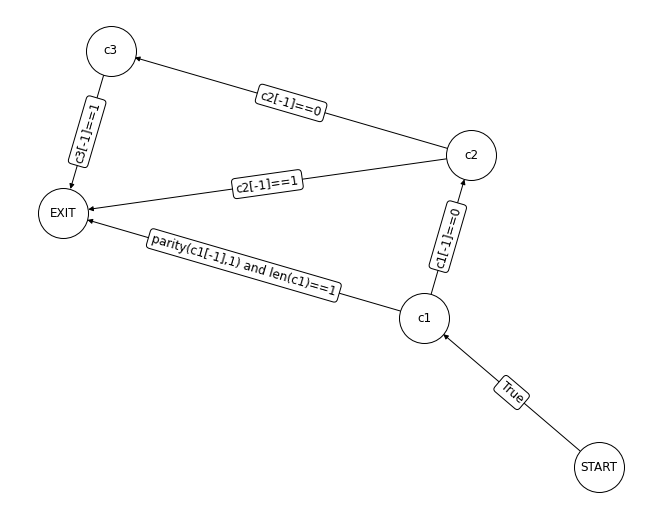

In [ ]:
p = Protocol()
p.add_nodes_from(['c1','c2','c3'], circuits=['a','b','c'])
p.add_edge('START', 'c1', check='True')
p.add_edge('c1', 'c2', check='c1[-1]==0')
p.add_edge('c2', 'c3', check='c2[-1]==0')

functions = {"parity": lambda x, y: bin(x).count('1') % 2 == y if x else False}

p.add_edge('c1', 'EXIT', check='parity(c1[-1],1) and len(c1)==1')
p.add_edge('c2', 'EXIT', check='c2[-1]==1')
p.add_edge('c3', 'EXIT', check='c3[-1]==1')

draw_protocol(p, figsize=(9,7), color=False)

Here another example for a more complex protocol:

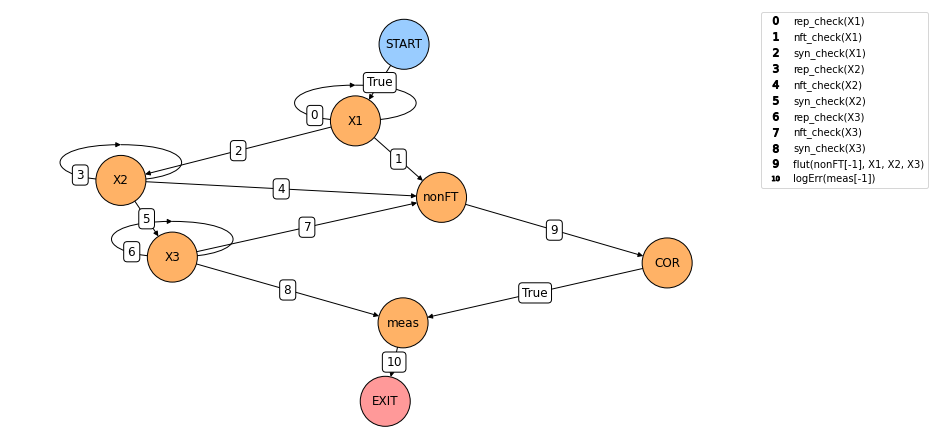

In [ ]:
init = Protocol()
init.add_nodes_from(['X1', 'X2', 'X3', 'nonFT', 'meas'], circuits=[])
init.add_node('COR', circuit=Circuit([{'I': set(range(7))}]))

init.add_edge('START', 'X1', check='True')

# no flag triggered, run second round regardless of syndrome
init.add_edge('X1', 'X1', check='rep_check(X1)')
init.add_edge('X2', 'X2', check='rep_check(X2)')
init.add_edge('X3', 'X3', check='rep_check(X3)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
init.add_edge('X1', 'nonFT', check='nft_check(X1)')
init.add_edge('X2', 'nonFT', check='nft_check(X2)')
init.add_edge('X3', 'nonFT', check='nft_check(X3)')

# no flag triggered, syndromes agree in second round
init.add_edge('X1', 'X2', check='syn_check(X1)')#False if rep_check(X1) or nft_check(X1) else True')
init.add_edge('X2', 'X3', check='syn_check(X2)')#'False if rep_check(X2) or nft_check(X2) else True')
init.add_edge('X3', 'meas', check='syn_check(X3)')#'False if rep_check(X3) or nft_check(X3) else True')

# apply flag correction after nonFT if a flag was triggered
init.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1, X2, X3)')

init.add_edge('COR', 'meas', check='True')

init.add_edge('meas', 'EXIT', check='logErr(meas[-1])')
draw_protocol(init, figsize=(10,6), self_loop_offset=(-0.05, 0.03), color=True, edge_legend=True)

We can simply iterate over the protocol by calling the `iterate` iterator function. We have to provide a measurement with each iteration which is used to evaluate the checks and to finally yield a following node. At the end of the protocol the iterator will return `None` which we can use as a exit condition for the while loop. Note that we need to always call `next()` on the iterator before we can `.send()` stuff to it.

In [ ]:
p_it = iterate(p, functions)
node = next(p_it)

while node:
    print(node)
    node = p_it.send(0)

c1
c2
c3


In [ ]:
#export
def save_protocol(protocol, fname, path='.'):
    """Saves a protocol to `path` with file name `fname`"""
    file = open(f'{path}/{fname}.proto', 'wb')
    pickle.dump(protocol,file)
    file.close()

In [ ]:
#export
def load_protocol(fname, path='.'):
    """Loads a protocol from `path` with file name `fname`"""
    file = open(f'{path}/{fname}.proto', 'rb')
    res = pickle.load(file)
    file.close()
    return res

We can also save and load protocols

In [ ]:
save_protocol(p, 'test_protocol')
p2 = load_protocol('test_protocol')
print(p2)

Protocol with 5 nodes and 6 edges
